In [1]:
# imports de preparação e construção do modelo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

# imports mlflows para modelo do sklearn
import mlflow
import mlflow.sklearn

In [2]:
credit = pd.read_csv('Credit.csv')

In [3]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
credit.shape

(1000, 21)

In [5]:
for col in credit.columns:
    if credit[col].dtype == 'object':
        credit[col] = credit[col].astype('category').cat.codes

In [6]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [7]:
previsores = credit.iloc[:, 0:20].values
classe = credit.iloc[:, 20].values

In [8]:
previsores

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]])

In [9]:
set(classe)

{0, 1}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(previsores, classe, train_size=0.7, random_state=123)

In [18]:
mlflow.set_experiment('rf-experiment')

def train_rf(n_estimators=10):
    with mlflow.start_run():
        rf = RandomForestClassifier(n_estimators=n_estimators)
        rf.fit(X=X_train, y=y_train)
        pred = rf.predict(X_test)

        # metricas de avaliação
        accuracy = accuracy_score(y_true=y_test, y_pred=pred)
        recall = recall_score(y_true=y_test, y_pred=pred)
        precision = precision_score(y_true=y_test, y_pred=pred)
        f1 = f1_score(y_true=y_test, y_pred=pred)
        auc = roc_auc_score(y_true=y_test, y_score=pred)
        log = log_loss(y_true=y_test, y_pred=pred)

        # graficos
        confusion = plot_confusion_matrix(rf, X_test, y_test)
        plt.savefig('confusion-rf.png')
        roc = plot_roc_curve(rf, X_test, y_test)
        plt.savefig('roc-rf.png')

        # registrar hiperparametros
        mlflow.log_param(key='n_estimators', value=n_estimators)

        # registrando metricas
        mlflow.log_metric(key='accuracy', value=accuracy)
        mlflow.log_metric(key='recall', value=recall)
        mlflow.log_metric(key='precision', value=precision)
        mlflow.log_metric(key='f1', value=f1)
        mlflow.log_metric(key='f1', value=f1)
        mlflow.log_metric(key='log', value=log)

        # registrando os graficos
        mlflow.log_artifact('confusion-rf.png')
        mlflow.log_artifact('roc-rf.png')

        # regisdtrando o modelo
        mlflow.sklearn.log_model(sk_model=rf, artifact_path='RF model')

        # info execucao
        print('Modelo: ', mlflow.active_run().info.run_uuid)

    mlflow.end_run()

2022/02/26 14:29:38 INFO mlflow.tracking.fluent: Experiment with name 'rf-experiment' does not exist. Creating a new experiment.


Modelo:  ad5372ba5f08461d891bbcde98e53adb
Modelo:  fb994070badb4001943b382af720c35a
Modelo:  8e2847fc63f4439d8212a82a5ba2f8a5
Modelo:  1d143ed650a74f7aa0741fca97c75055
Modelo:  e0d1d030a5fc4caf8e7d424d5c817344
Modelo:  042c71449d6d42f1b4e50fdf06481b49
Modelo:  01eae6f205b542658ba9d196af3643c0
Modelo:  6221a28b809c4a9b8a02c3b62758b09d
Modelo:  d2fb736348d648de8ac2b0c78fb584da
Modelo:  0179c92ad77b417f881b8549366e2435


/home/lps/anaconda3/envs/ia/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Modelo:  20c53a516375462d839d29e8f4fde9f3
Modelo:  850a02ad2a6349a387fbb6e85e19a08a


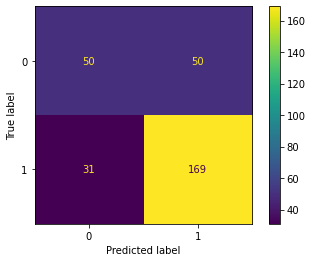

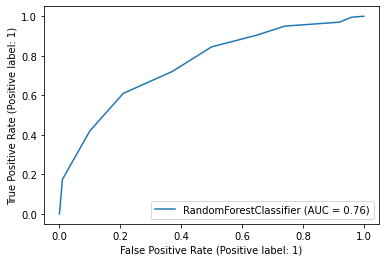

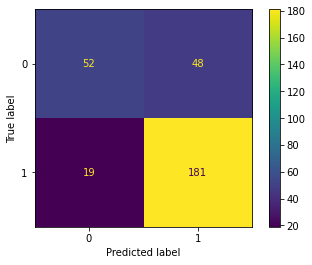

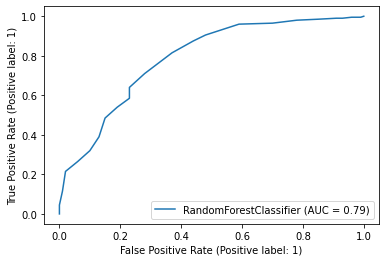

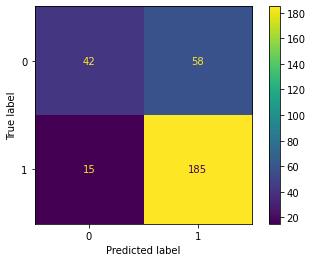

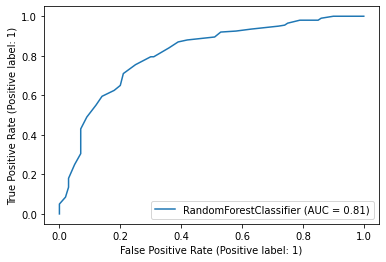

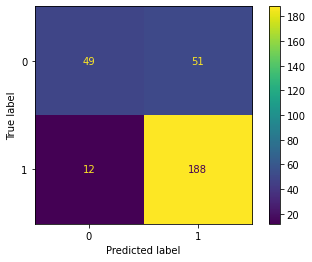

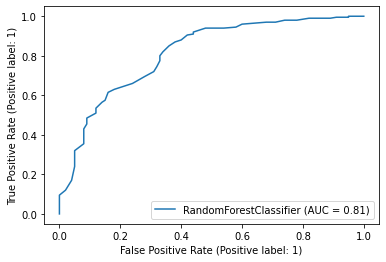

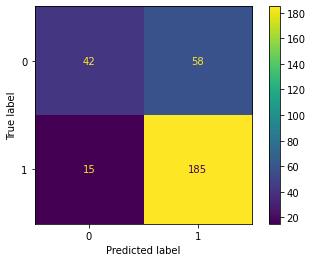

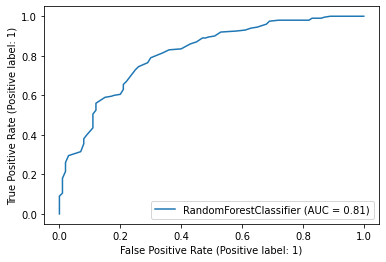

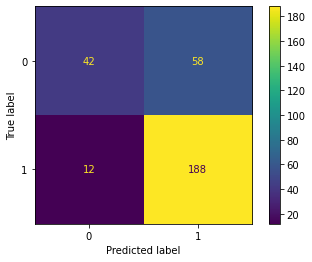

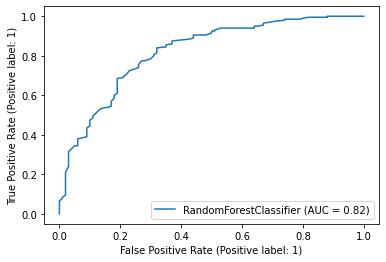

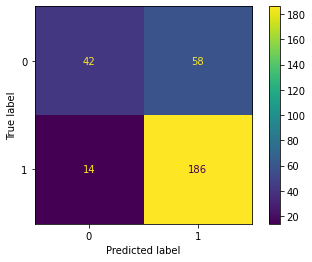

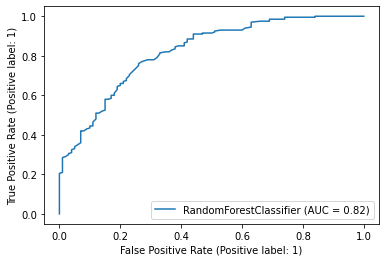

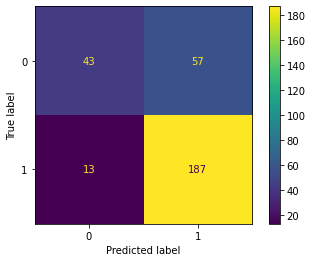

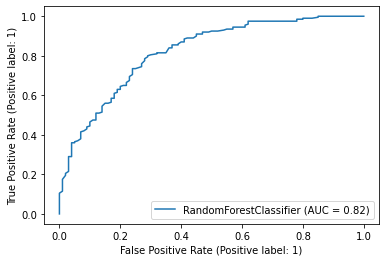

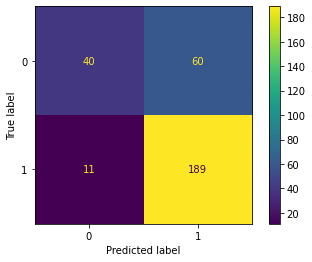

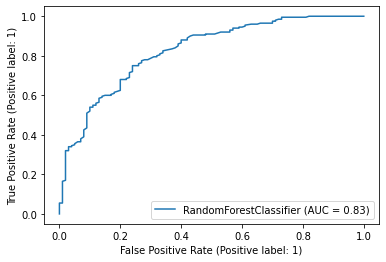

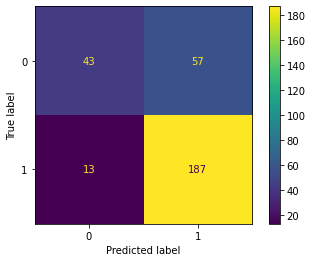

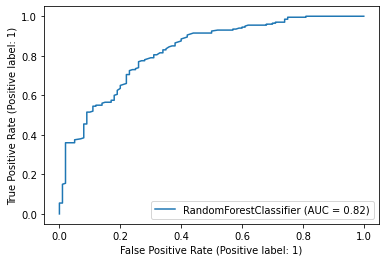

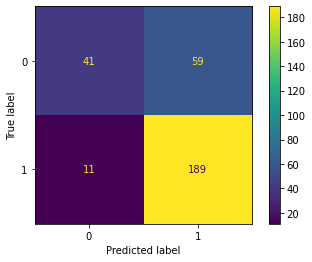

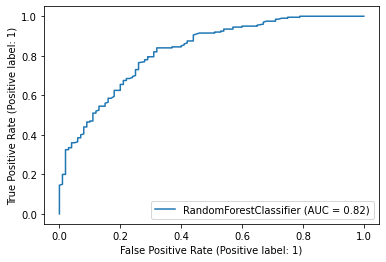

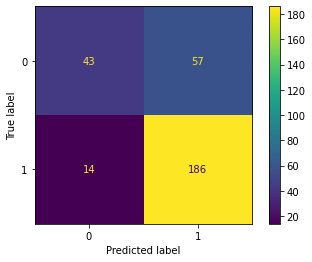

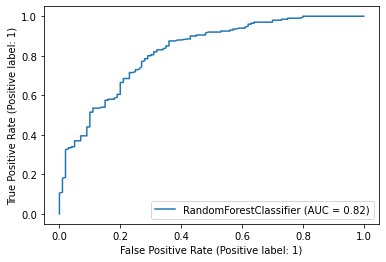

In [19]:
for estimators in [10, 30, 50, 80, 100, 200, 300, 400, 500, 800, 1000, 1200]:
    train_rf(n_estimators=estimators)